# Leverage reflectance data cube to monitor vegetation growth

This notebook illustrate how to highlight vegetation growth using a reflectance datacube.

For this example the data cube has been generated using https://github.com/earthdaily/reflectance-datacube-processor with the following parameters:
- Geometry: "MULTIPOLYGON (((1.4086350057776444 43.21690230694904, 1.4089366117196283 43.21714799614918, 1.4089366785528101 43.217148050591405, 1.4089367429293527 43.217148106594735, 1.4090182158741127 43.21721898255213, 1.4092399203995147 43.21741184933847, 1.4092419880263154 43.21741364801513, 1.4092419893842905 43.21741364919645, 1.4092419907411549 43.21741365037846, 1.4095038648851337 43.217641777252766, 1.4095039972857262 43.21764189259052, 1.4095041188405077 43.21764201414746, 1.409683957063414 43.21782185486959, 1.4101011631607383 43.21755504286137, 1.4101012038961362 43.217555016810046, 1.410101245252057 43.21755499128702, 1.4103364189674379 43.21740985198667, 1.410316800608727 43.21738238652239, 1.410291174315395 43.21734650997858, 1.410290981873531 43.217346240561795, 1.410290741615299 43.21734599253314, 1.4102198817495866 43.21727284080838, 1.4102197752815013 43.217272730896575, 1.4102196600105419 43.21727262584178, 1.4101566882069754 43.21721523500227, 1.4101566417021965 43.21721519261899, 1.4101565966112017 43.21721514942624, 1.410105702123445 43.21716639747778, 1.4101056082929033 43.21716630759719, 1.410105520756938 43.217166214381415, 1.4099197351561505 43.21696837316775, 1.409916841951658 43.216965681177115, 1.4099132703648907 43.216962357983284, 1.4099175840590985 43.2169595448928, 1.4103347379443636 43.216687504144936, 1.4103356176897455 43.21668693042762, 1.4103367251388053 43.21668663528737, 1.4103685685885679 43.216678148855635, 1.409905269042236 43.21618928982496, 1.4086350057776444 43.21690230694904)))"
- Collection: Sentinel-2-l2a
- Dates: 2020-11-01 to 2021-09-15
- Assets: red, nir, swir16, swir22, red edge1, red edge2, red edge3 
- Coverage: 100

In [1]:
import sys
import os
sys.path.append(os.path.join('..','src'))
from dotenv import load_dotenv
load_dotenv()
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from utils.utils import open_datacube
from cloudpathlib import S3Path, AzureBlobClient, AzureBlobPath


## 1️⃣ Load Datacube from Cloud Storage (AWS or Azure)

- Load Datacube from AWS

In [ ]:
image = S3Path("s3://" + os.getenv("AWS_BUCKET_NAME") + "/2020-11-01_2021-09-15_digital_ag_field3_sentinel-2-l2a_datacube.zarr")
cube = open_datacube(image)

- Load Datacube from Azure Cloud Storage

In [2]:
# Init Azure account/credentials
account_url = f"https://{os.environ['AZURE_ACCOUNT_NAME']}.blob.core.windows.net"
az_client = AzureBlobClient(account_url, credential = os.environ['AZURE_SAS_CREDENTIAL'])

In [ ]:
# Load datacube with the Agro Cloud Mask
uri = "az://" + os.getenv("AZURE_BLOB_CONTAINER_NAME") + "/2020-11-01_2021-09-15_digital_ag_field3_sentinel-2-l2a_datacube.zarr"
path = AzureBlobPath(uri,client=az_client)
cube = open_datacube(path)

## 2️⃣ NDVI index to plot the field vegetation

In [4]:
# NDVI formula
def NDVI(red,nir):
    return  ((nir - red)/(nir + red))

In [5]:
#selection of dates
datacube_season_1 = cube.sel(time=slice('2020-11-26T00:00:00.000000000','2021-09-12T00:00:00.000000000'))

#NDVI images computing for all dates
dates_1=[]
NDVIs=[]
for date,cube_date in datacube_season_1.groupby('time',squeeze=False):
    NDVIs.append(NDVI(cube_date.red,cube_date.nir))
    dates_1.append(date)
print(len(NDVIs))

18


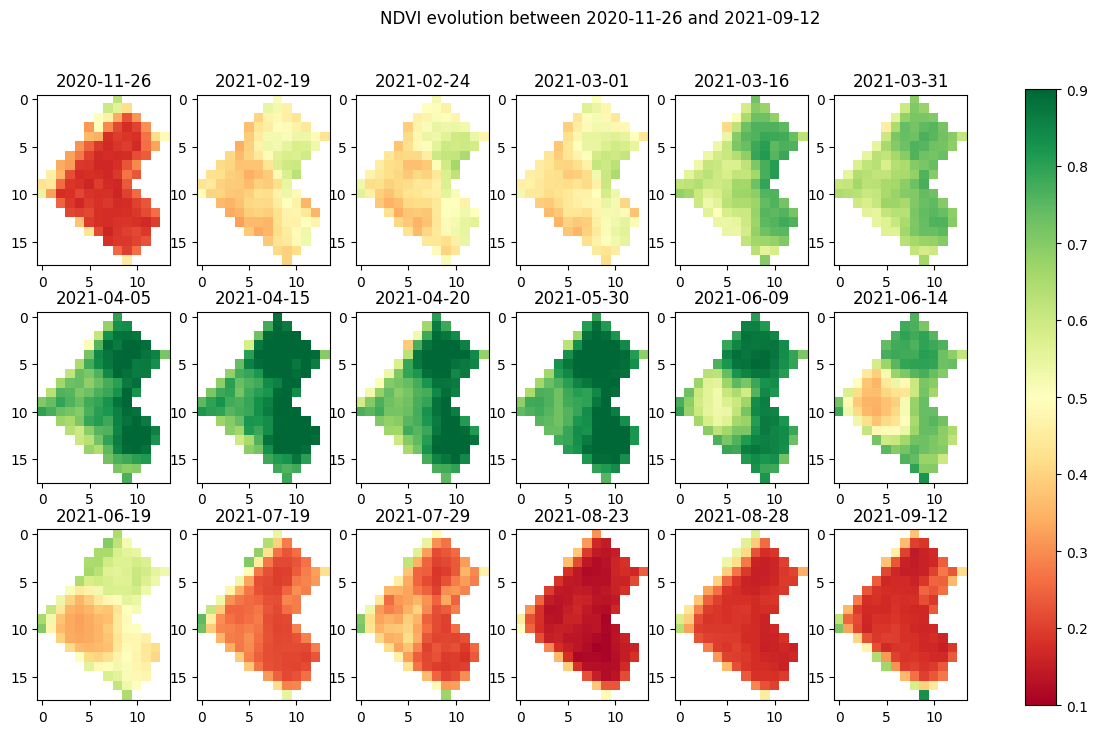

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=6,figsize=(15, 8))
fig.suptitle(f'NDVI evolution between {str(dates_1[0])[:10]} and {str(dates_1[-1])[:10]}')
for i, ax in enumerate(axes.flat):
    ax.set_title(str(dates_1[i])[:10])
    im = ax.imshow(NDVIs[i][0],vmin=0.1,vmax=0.9,cmap='RdYlGn')
cax,kw = mpl.colorbar.make_axes(list(axes.flat))
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

From what we can see here, vegetation really emergesat the end of March. Before that, it's actually harder to spot any vehetation growth on the field. To see more difference, we can use the MSAVI index which will have more insights on what's happening before the full vegetation period.

 ## 3️⃣ MSAVI index for low vegetated fields

To properly use the MSAVI index, we need to select the time for our cube before anything happens until the fully vegetated step, which we can see on April 15th 2021. We are going to compute the MSAVI index for all the dates to study the difference in growth vegetation in early stages.

In [8]:
#MSAVI formula
def MSAVI(red,nir):
    return((2*nir +1 - np.sqrt((2*nir+1)**2 - 8*(nir - red)))/2)

In [9]:
#selection of dates
datacube_season_2 = cube.sel(time=slice('2020-11-26T00:00:00.000000000','2021-09-12T00:00:00.000000000'))

#NDVI images computing for all dates
dates_2=[]
MSAVIs = []
for date,cube_date in datacube_season_2.groupby('time',squeeze=False):
    MSAVIs.append(MSAVI(cube_date.red,cube_date.nir))
    dates_2.append(date)
print(len(MSAVIs))

18


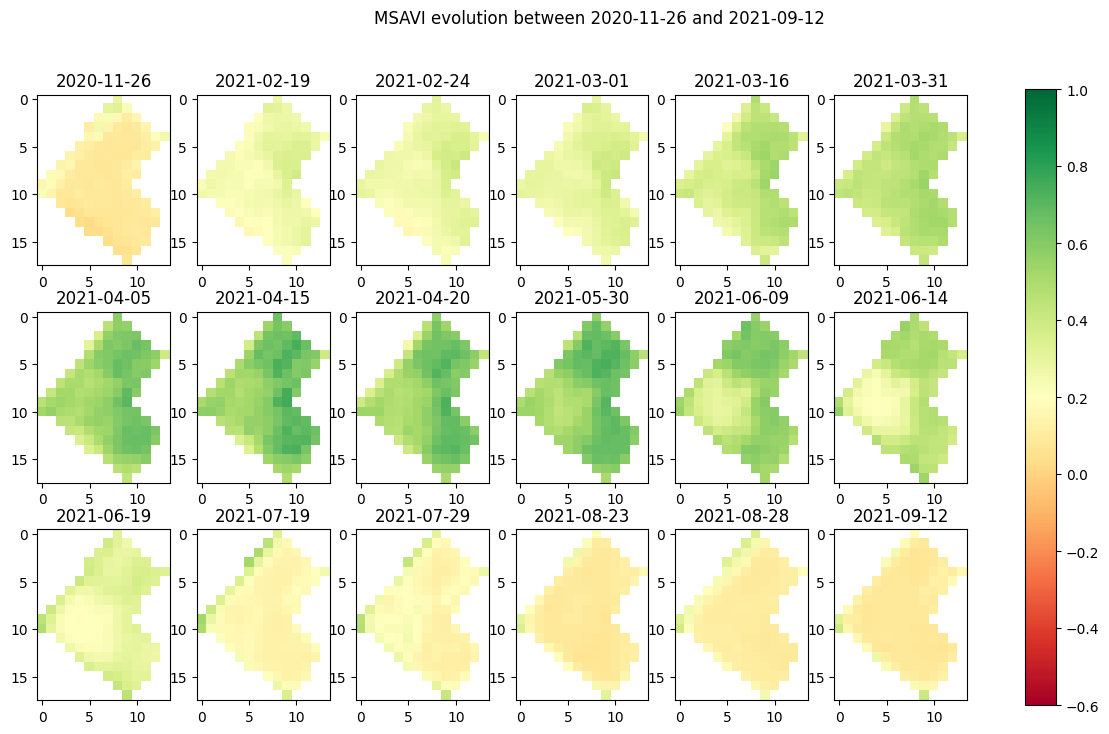

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=6,figsize=(15, 8))
fig.suptitle(f'MSAVI evolution between {str(dates_2[0])[:10]} and {str(dates_2[-1])[:10]}')
for i, ax in enumerate(axes.flat):
    ax.set_title(str(dates_2[i])[:10])
    im = ax.imshow(MSAVIs[i][0],vmin=-0.6,vmax=1,cmap='RdYlGn')
cax,kw = mpl.colorbar.make_axes(list(axes.flat))
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

The MSAVI index allow us to see more differences in the fields when the vegetation is low. We can see that the growth is uneven and it allows us to see that the growth mostly start on right side of the field. After the vegetation peak, the MSAVI index is saturating and that's when we can use NDVI to actually spot differences on the vegetation health.

The different spectral indexes in general allow us to see intra field variability during the different phenology key stages such as emergence, flowering or even harvest.